# 0 - Instalation of modules

In [ ]:
#Run this cell to have the progress bar
%pip install tqdm
%pip install ipywidgets
%jupyter nbextension enable --py widgetsnbextension
%pip install scikit-learn

# 1 - Importing modules

In [3]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import cosine_similarity as cos_dist
import matplotlib.pyplot as plt

# 2 - Get all files needed

In [1]:
data_folder = "../../Dataset/Movie/"

In [40]:
rating = pd.read_csv(f"{data_folder}ratings.csv").drop(["timestamp"], axis=1)
movie = pd.read_csv(f"{data_folder}movies.csv")

data = pd.merge(movie, rating, on="movieId").drop(["genres", "movieId"], axis=1)
data.shape

(25000095, 3)

# 3 - Transforming data

In [41]:
#We keep only the NB_FILM most rated movies
NB_FILM = 500
keep_title = data["title"].value_counts().sort_values(ascending=False)[:NB_FILM].index
data_title = data[data["title"].isin(keep_title)]
data_title.shape

(10944751, 3)

In [42]:
#We keep only users that rated at least THRESH_USER % of movies
THRESH_USER = 0.40
keep_user = data_title["userId"].value_counts()/NB_FILM >= THRESH_USER
data_title_user = data_title[data_title["userId"].isin(keep_user[keep_user].index)]

In [43]:
#Pivot table
user_title_df = data_title_user.pivot_table(index="userId", columns="title", values="rating")
user_title_df.to_csv(f"{data_folder}test_for_users.csv")
user_title_df.shape

(10103, 500)

In [4]:
#If data are already in local files, we can get it.
user_title_df = pd.read_csv(f"{data_folder}test_for_users.csv", index_col=0)
user_title_df.shape

(10103, 500)

# 4 - Colaborative filtering

In [7]:
#Standardization of row
def normalization_mean(row):
    return row - row.mean()

def normalization_min_max(row):
    return (row - row.mean())/(row.max() - row.min())

def normalization_std(row):
    return (row - row.mean())/row.std()  

#Cosine distance between [0,1]
def cosine_similarity(X):
    return (cos_dist(X)+1)/2

## 4.1 - Users to users

In [8]:
#We applied all standardization to data, for different tests.
for_users_data = {}
for_users_data["min_max"] = user_title_df.fillna(0).apply(normalization_min_max, axis=1)
for_users_data["mean"] = user_title_df.fillna(0).apply(normalization_mean, axis=1)
for_users_data["std"] = user_title_df.fillna(0).apply(normalization_std, axis=1)

In [12]:
#Creation of the distance matrix with multiple distance methods
all_users = user_title_df.index
similarity_users = {"Cosinus" : {}, "Pearson" : {}}

for method in for_users_data.keys():
    cos = cosine_similarity(for_users_data[method])
    similarity_users["Cosinus"][method] = pd.DataFrame(cos, index=all_users, columns=all_users)
    np.fill_diagonal(similarity_users["Cosinus"][method].values, 0)

    corr = (np.corrcoef(for_users_data[method])+1)/2
    similarity_users["Pearson"][method] = pd.DataFrame(corr, index=all_users, columns=all_users)
    np.fill_diagonal(similarity_users["Pearson"][method].values, 0)

del(cos)
del(corr)

In [13]:
#Guess rate of movie for specific user
def guess_rate(user, title, distance, method, N):
    similar_mat = similarity_users[distance][method]
    all_similar_users = similar_mat.loc[user].sort_values(ascending=False).index
    user_title_mat = for_users_data[method]
    
    rate = 0
    weight = 0
    k = 0
    i = 0

    while (k < N):
        similar_user = all_similar_users[i]
        r = user_title_mat.loc[similar_user, title]

        if not (pd.isnull(r)):
            w = similar_mat.loc[similar_user, user]
            rate += w*r
            weight += w
            k += 1

        i += 1

    return rate/weight

In [15]:
#Get all the similar movies for specific user
def get_similar_movies_from_users(user_id, distance, method, N):
    all_rates = []
    keep_movies = []

    for movie in tqdm(user_title_df.columns):
        if (pd.isnull(user_title_df.loc[user_id, movie])):
            all_rates.append(guess_rate(user_id, movie, distance, method, N))
            keep_movies.append(movie)

    return pd.Series(all_rates, keep_movies).sort_values(ascending=False)

In [16]:
#Test to see if there is a difference between all distance methods.
similar_movies = {"Cosinus" : {"min_max" : [], "mean" : [], "std" : []}, "Pearson" : {"min_max" : [], "mean" : [], "std" : []}}

for distance in similar_movies.keys():
    for method in similar_movies[distance].keys():
        similar_movies[distance][method] = get_similar_movies_from_users(12, distance, method, 10).index

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [17]:
cos_recommanded = pd.DataFrame.from_dict(similar_movies["Cosinus"])
corr_recommanded = pd.DataFrame.from_dict(similar_movies["Pearson"])
((cos_recommanded == corr_recommanded).all()).all()
#There is no difference between distance methods

True

In [18]:
(cos_recommanded["min_max"] == cos_recommanded["mean"]).all()       #100% similar
np.mean(cos_recommanded["min_max"] == cos_recommanded["std"])*100   #37% similar
#Min max and mean method are similar but std method is different.

37.096774193548384

In [19]:
#What is the difference between min max and std method ?
k = 0
arg_diff = []
for movie in cos_recommanded["min_max"].values:
    arg = np.where(cos_recommanded["std"] == movie)[0][0]
    if (arg != k):
        arg_diff.append(abs(k-arg))
    k += 1
np.mean(arg_diff)
#There is an average difference of 2/3 places between the rankings of the two methods.

2.641025641025641

In [20]:
#We compare all the compute time for all methods and distances
from time import time

NB_USER = 20
NB_MOVIE = 20
MAX = 100
STEP = 2

stats = {}

for N in tqdm([i*STEP for i in range(1, MAX)]):
    for distance in ["Cosinus", "Pearson"]:
        stats[distance] = {"min_max" : [], "mean" : [], "std" : []}

        for user_id in user_title_df.index[:NB_USER]:
            all_rated_movies = user_title_df.loc[user_id].dropna()[:NB_MOVIE]

            for movie in all_rated_movies.index:
                for method in ["min_max", "mean", "std"]:
                    start = time()
                    rate = guess_rate(user_id, movie, distance, method, N)
                    stats[distance][method].append(time() - start)

  0%|          | 0/99 [00:00<?, ?it/s]

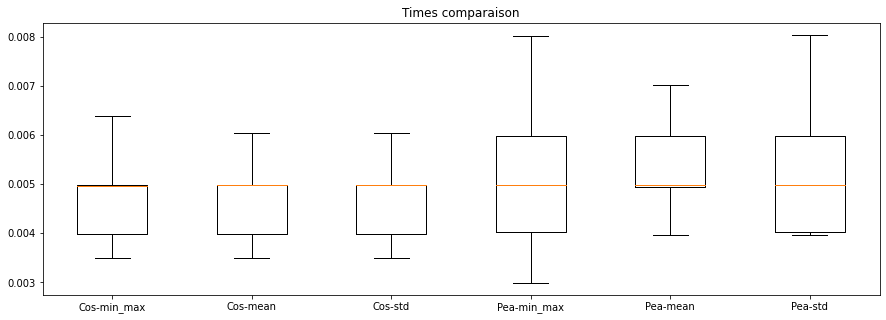

In [21]:
plt.figure(figsize=(15, 5))

plots = []
labels = []

for distance in stats.keys():
    for method in stats[distance].keys():
        plots.append(stats[distance][method])
        labels.append(f"{distance[:3]}-{method}")

plt.boxplot(plots, labels=labels, showfliers=False)
plt.title("Times comparaison")
plt.show()

We can see that cosine method seems to compute faster than pearson distance. There no difference between standardization methods.

## 4.2 - Movie to movie

In [22]:
#We applied all standardization to data, for different tests.
for_movies_data = {}
for_movies_data["min_max"] = user_title_df.fillna(0).apply(normalization_min_max, axis=0)
for_movies_data["mean"] = user_title_df.fillna(0).apply(normalization_mean, axis=0)
for_movies_data["std"] = user_title_df.fillna(0).apply(normalization_std, axis=0)

In [23]:
#Creation of the distance matrix with multiple distance methods
all_movies = user_title_df.columns
similarity_movies = {"Cosinus" : {}, "Pearson" : {}}

for method in for_movies_data.keys():
    cos = cosine_similarity(for_movies_data[method].T)
    similarity_movies["Cosinus"][method] = pd.DataFrame(cos, index=all_movies, columns=all_movies)
    np.fill_diagonal(similarity_movies["Cosinus"][method].values, 0)

    corr = np.corrcoef(for_movies_data[method].T)
    similarity_movies["Pearson"][method] = pd.DataFrame(corr, index=all_movies, columns=all_movies)
    np.fill_diagonal(similarity_movies["Pearson"][method].values, 0)

del(cos)
del(corr)

In [24]:
#Get all similar movies for a specific movie.
def get_similar_movies_from_movies(user_id, distance, method):
    similar_movies = []

    movies_rates = user_title_df.loc[user_id].dropna()
    movies = movies_rates.index
    rates = movies_rates.values
    user = [(movies[i], rates[i]) for i in range(len(rates))]

    for movie, rate in tqdm(user):
        movie_list = (similarity_movies[distance][method].loc[:, movie]*(rate-2.5)).sort_values(ascending=False)
        similar_movies.append(movie_list)

    similar_movies = pd.concat(similar_movies, axis=1)
    similar_movies = similar_movies.drop([movie for movie, rate in user], axis=0)
    return similar_movies.sum(axis=1).sort_values(ascending=False)

In [25]:
#Test to see if there is a difference between all distance methods.
similar_movies = {"Cosinus" : {"min_max" : [], "mean" : [], "std" : []}, "Pearson" : {"min_max" : [], "mean" : [], "std" : []}}

for distance in similar_movies.keys():
    for method in similar_movies[distance].keys():
        similar_movies[distance][method] = get_similar_movies_from_movies(12, distance, method).index

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

In [26]:
cos_recommanded = pd.DataFrame.from_dict(similar_movies["Cosinus"])
corr_recommanded = pd.DataFrame.from_dict(similar_movies["Pearson"])
((cos_recommanded == corr_recommanded).all()).all()
#No difference between distance methods

True

In [27]:
(cos_recommanded["min_max"] == cos_recommanded["mean"]).all() 
(cos_recommanded["min_max"] == cos_recommanded["std"]).all()
#No difference between standardization methods

True

## 4.3 - Mix

In [28]:
#First method to combine the two methods
def recommanded_movies_2(user_id):
    distance = "Cosinus"
    method = "min_max"

    get_users = get_similar_movies_from_users(user_id, distance, method, 15)
    get_movies = get_similar_movies_from_movies(user_id, distance, method)
    get_users.name = "User Values"
    get_movies.name = "Movie Values"

    df = pd.merge(get_users, get_movies, left_index=True, right_index=True)
    df["Somme"] = df["User Values"] + df["Movie Values"]

    return df.sort_values("Somme", ascending=False)
        

In [29]:
#Second method to combine the two methods
def recommanded_movies(user_id):
    distance = "Cosinus"
    method = "min_max"
    
    get_users = get_similar_movies_from_users(user_id, distance, method, 500)
    get_movies = get_similar_movies_from_movies(user_id, distance, method)

    arg_movies = []
    for title in get_users.index:
        arg_movies.append(int(np.argwhere(get_movies.index == title)))

    recommanded = pd.DataFrame(index=get_users.index, columns=["Arg Users", "Arg Movies"], data=np.array([range(len(arg_movies)), arg_movies]).T)
    recommanded["Mean"] = recommanded.mean(axis=1)

    return recommanded.sort_values(by="Mean")

In [30]:
#Compare the two combine methods
test1 = recommanded_movies_2(12)
test2 = recommanded_movies(12)

k = 0
arg_diff = []
for movie in test1.index:
    arg = np.where(test2.index == movie)[0][0]
    if (arg != k):
        arg_diff.append(abs(k-arg))
    k += 1
np.mean(arg_diff)
#There is an average difference of 17/18 places between the rankings of the two methods.

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

17.8744769874477

In [31]:
test2

,Arg Users,Arg Movies,Mean
"Graduate, The (1967)",5,0,2.5
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),0,16,8.0
One Flew Over the Cuckoo's Nest (1975),2,18,10.0
Traffic (2000),13,8,10.5
Chasing Amy (1997),21,6,13.5
...,...,...,...
"Wolf of Wall Street, The (2013)",239,240,239.5
Deadpool (2016),246,241,243.5
Interstellar (2014),244,247,245.5
Intouchables (2011),245,246,245.5
